# Desafio 2 - Maratona Behind the Code 2021

## Bibliotecas

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display
from sklearn.model_selection import train_test_split

Se necessário, instale o cloudant:

In [2]:
# !pip install cloudant

## Configurações

In [3]:
seed = 0

## Dados

### Obtenção dos dados de IOT

In [4]:
def get_df(file_name):
    try:
        # When running locally
        result = pd.read_csv(file_name)
    except FileNotFoundError:
        try:
            # When running on IBM cloud
            from project_lib import Project

            PROJECT_ID = os.getenv("PROJECT_ID")
            PROJECT_ACCESS_TOKEN = os.getenv("PROJECT_ACCESS_TOKEN")
            project = Project(
                project_id=PROJECT_ID, project_access_token=PROJECT_ACCESS_TOKEN
            )
            try:
                # When available on assets
                result = read_from_assets(project, file_name)
            except RuntimeError as e:
                # When not available on assets
                df = get_from_cloudant()
                project.save_data(file_name=file_name, data=df.to_csv(index=False))
                result = read_from_assets(project, file_name)
        except ModuleNotFoundError:
            df = get_from_cloudant()
            df.to_csv(file_name, index=False)
            result = pd.read_csv(file_name)
    return result


def read_from_assets(project, file_name):
    file = project.get_file(file_name)
    file.seek(0)
    return pd.read_csv(file)


def get_from_cloudant():
    print("Getting data from cloudant...")
    from cloudant import Cloudant

    CLOUDANT_USER = os.getenv("CLOUDANT_USER")
    CLOUDANT_PASSWORD = os.getenv("CLOUDANT_PASSWORD")
    client = Cloudant(
        CLOUDANT_USER,
        CLOUDANT_PASSWORD,
        account=CLOUDANT_USER,
        connect=True,
        auto_renew=True,
    )
    db = client["quanam-iot"]
    response = db.all_docs(include_docs=True)
    docs = [row["doc"] for row in response["rows"]]
    challenge_columns = ["ID", "ILLUM", "HUMID", "CO2", "SOUND", "TEMP", "RYTHM"]
    return pd.DataFrame(docs)[challenge_columns].copy()

In [5]:
df = get_df("iot.csv")

### Informações gerais

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3200 non-null   int64  
 1   ILLUM   3200 non-null   float64
 2   HUMID   3200 non-null   float64
 3   CO2     3200 non-null   float64
 4   SOUND   3200 non-null   float64
 5   TEMP    3200 non-null   float64
 6   RYTHM   3200 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 175.1 KB


Neste conjunto de dados:
- Todas as variáveis (colunas) são numéricas.
- Não há dados faltantes.

### Divisão entre treino e teste

Antes de inspecionar os dados, serão reservados alguns exemplos para teste, que não serão vistos durante a análise ou modelagem dos dados:

In [7]:
test_size = 500
target = "RYTHM"
df_train, df_test = train_test_split(df, test_size=test_size, random_state=seed)
print(f"Dimensões dos dados de treino: {df_train.shape}")
print(f"Dimensões dos dados de teste: {df_test.shape}")

Dimensões dos dados de treino: (2700, 7)
Dimensões dos dados de teste: (500, 7)


### Dados de exemplo

In [8]:
with pd.option_context("display.max_rows", 4):
    display(df_train)

,ID,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
953,761,542.20,73.02,394.17,32.23,19.85,77.74
1633,2769,495.97,71.16,572.84,39.30,18.21,83.36
...,...,...,...,...,...,...,...
2607,1396,321.95,66.36,449.71,22.12,20.63,74.34
2732,2990,553.35,61.47,495.48,32.51,18.17,83.19


### Variável destino

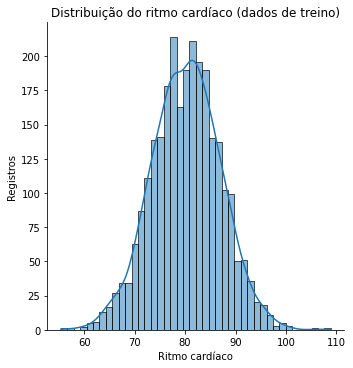

In [9]:
sns.displot(df_train[target], kde=True)
plt.xlabel("Ritmo cardíaco")
plt.ylabel("Registros")
plt.title("Distribuição do ritmo cardíaco (dados de treino)")
plt.show()

### Estatísticas

In [10]:
df_train.describe()

,ID,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.00000,2700.000000
mean,1599.107037,440.199700,67.121793,501.447263,29.768244,20.04547,80.212707
std,928.089673,89.861751,4.787193,43.007247,6.144921,1.66544,6.759542
min,1.000000,145.480000,51.860000,352.820000,8.060000,14.76000,55.370000
25%,790.750000,377.692500,63.770000,470.540000,25.490000,18.90000,75.730000
50%,1603.000000,437.745000,66.950000,502.005000,29.795000,20.05000,80.280000
75%,2403.250000,501.452500,70.410000,530.140000,33.850000,21.20000,84.712500
max,3200.000000,775.140000,83.900000,672.380000,53.780000,26.29000,108.900000


### Correlações

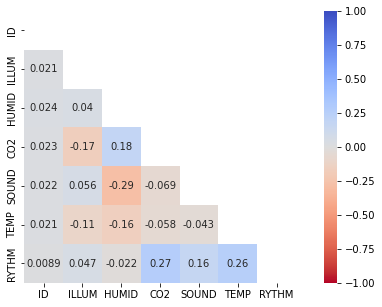

In [11]:
plt.subplots(figsize=(10, 5))
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, square=True, vmin=-1.0, vmax=1.0, cmap="coolwarm_r", mask=mask)
plt.show()

- O ritmo cardíaco tem maior correlação positiva com os níveis de CO2, e negativa com a umidade

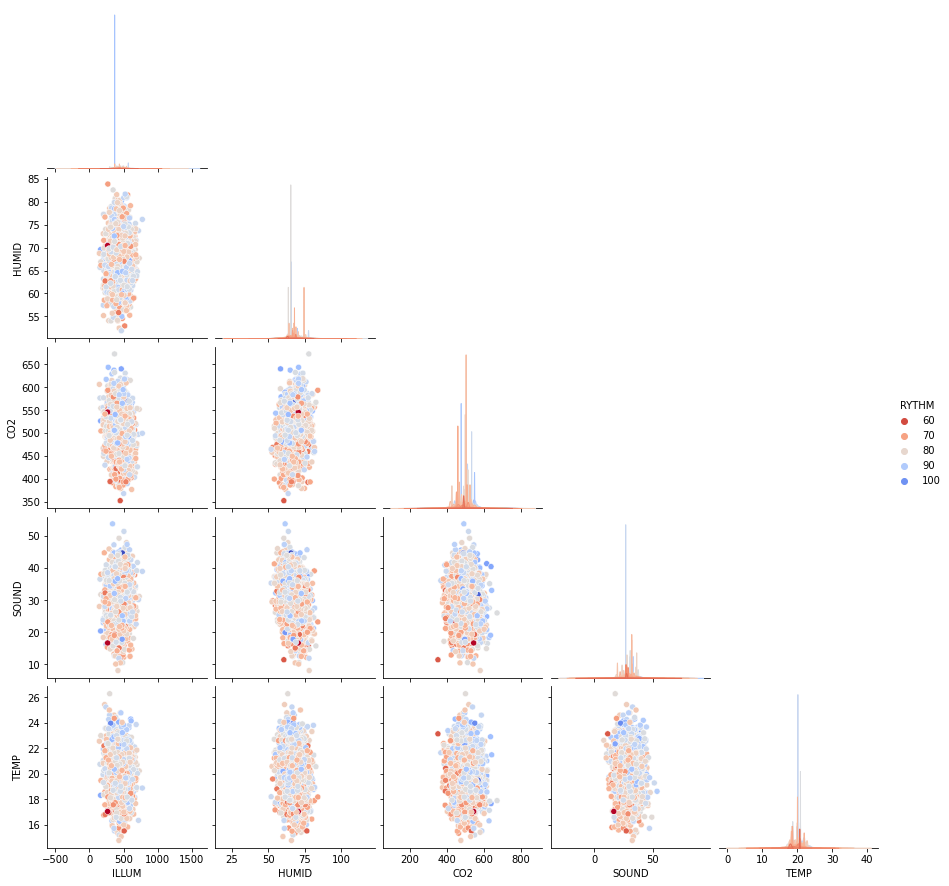

In [12]:
sns.pairplot(df_train.drop('ID', axis=1), hue=target, corner=True, palette="coolwarm_r")
plt.show()

In [13]:
import os
from datetime import timedelta
from pathlib import Path
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from dotenv import find_dotenv, load_dotenv
from ibm_watson_machine_learning import APIClient
from IPython.display import HTML, display
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              ExtraTreesClassifier, RandomForestClassifier,
                              StackingClassifier)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV  # , RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score

In [14]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', Lasso(random_state=seed))
])

In [15]:
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2700, 6)
(2700,)
(500, 6)
(500,)


In [16]:
param_grid = [
    {
    'scaler': [RobustScaler(), MinMaxScaler()],
    'clf': [Ridge()],
    'clf__alpha': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    },
    {
    'scaler': [StandardScaler(), RobustScaler()],
    'clf': [ElasticNet()],
    'clf__alpha': [0.001, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.01, 0.03],
    },
    {
    'scaler': [MinMaxScaler()],
    'clf': [Lasso()],
    'clf__alpha' : [0.0005, 0.0008, 0.001, 0.003],
    'clf__max_iter': [200, 300, 400],
    'clf__positive': [True]
    },
    {
    'scaler': [RobustScaler(), MinMaxScaler(), 'passthrough'],
    'clf': [RandomForestRegressor()],
    'clf__n_estimators' : [100, 130, 150, 180, 200, 230, 250, 280, 300],
    'clf__max_features': ['sqrt', 0.4, 0.5, 0.6],
    'clf__criterion' : ['mae'],
    },
    {
    'scaler': [StandardScaler(), 'passthrough'],
    'clf': [GradientBoostingRegressor()],
    'clf__n_estimators': [120, 140, 150, 160, 170],
    'clf__learning_rate' : [0.09, 0.1, 0.11, 0.2, 0.3],
    'clf__max_depth': [1, 2, 3],
    'clf__alpha' : [0.3, 0.4, 0.5, 0.6, 0.7],
    }
]

In [17]:
cv_num = 10
verbose = 1
scoring = ['r2', 'neg_root_mean_squared_error', 'max_error', 'neg_mean_absolute_error']

cv_train_size = int(((cv_num - 1) / cv_num) * len(X_train))
cv_test_size = len(X_train) - cv_train_size


# cv = RandomizedSearchCV(pipe, param_distributions=param_grid, n_jobs=-1, verbose=verbose, random_state=seed,
#                           cv=cv_num, n_iter=15, scoring=scoring)
cv = GridSearchCV(pipe, param_grid, cv=cv_num, n_jobs=-1, verbose=verbose, scoring=scoring, refit=scoring[0])

start = timer()
cv.fit(X_train, y_train)
end = timer()
print(f'Tempo gasto para treinar o modelo {cv_num} vezes com cada combinação de parâmetros para encontrar a melhor: {timedelta(seconds=end-start)}')

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed: 57.0min
[Parallel(n_jobs=-1)]: Done 1890 tasks      | elapsed: 63.1min
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed: 64.1min
[Parallel(n_jobs=-1)]: Done 3090 tasks      | elapsed: 65.2min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed: 66.6min
[Parallel(n_jobs=-1)]: Done 4690 tasks      | elapsed: 68.0min
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed: 69.8min
[Parallel(n_jobs=-1)]: Done 6690 tasks      | elapsed: 71.6min
[Parallel(n_jobs=-1)]: Done 7840 tasks      | elapsed: 73.7min


Tempo gasto para treinar o modelo 10 vezes com cada combinação de parâmetros para encontrar a melhor: 1:15:47.439301


[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 75.8min finished


In [18]:
display(HTML('<h4>Dados brutos da validação cruzada</h4>'))
print(f'Cada combinação de parâmetros foi utilizada em {cv_num} rodadas de treino com {cv_train_size} exemplos e teste com {cv_test_size}.')

rank_col = 'rank_test_' + scoring[0]
cv_df = pd.DataFrame(cv.cv_results_).sort_values(rank_col).set_index(rank_col)

cols = [f'mean_test_{item}' for item in scoring] + ['mean_fit_time', 'params']
with pd.option_context('display.max_colwidth', None):
    display(cv_df[cols].head(20))


Cada combinação de parâmetros foi utilizada em 10 rodadas de treino com 2430 exemplos e teste com 270.


,mean_test_r2,mean_test_neg_root_mean_squared_error,mean_test_max_error,mean_test_neg_mean_absolute_error,mean_fit_time,params
rank_test_r2,,,,,,
1,0.196806,-6.046767,-18.824292,-4.829016,0.014126,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0005, 'clf__max_iter': 200, 'clf__positive': True, 'scaler': MinMaxScaler()}"
1,0.196806,-6.046767,-18.824292,-4.829016,0.008361,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0005, 'clf__max_iter': 300, 'clf__positive': True, 'scaler': MinMaxScaler()}"
1,0.196806,-6.046767,-18.824292,-4.829016,0.009025,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0005, 'clf__max_iter': 400, 'clf__positive': True, 'scaler': MinMaxScaler()}"
4,0.196806,-6.046778,-18.821825,-4.829000,0.008393,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0008, 'clf__max_iter': 400, 'clf__positive': True, 'scaler': MinMaxScaler()}"
4,0.196806,-6.046778,-18.821825,-4.829000,0.008183,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0008, 'clf__max_iter': 300, 'clf__positive': True, 'scaler': MinMaxScaler()}"
4,0.196806,-6.046778,-18.821825,-4.829000,0.008377,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0008, 'clf__max_iter': 200, 'clf__positive': True, 'scaler': MinMaxScaler()}"
7,0.196805,-6.046788,-18.820180,-4.828995,0.009453,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.001, 'clf__max_iter': 400, 'clf__positive': True, 'scaler': MinMaxScaler()}"
7,0.196805,-6.046788,-18.820180,-4.828995,0.013338,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.001, 'clf__max_iter': 300, 'clf__positive': True, 'scaler': MinMaxScaler()}"
7,0.196805,-6.046788,-18.820180,-4.828995,0.008202,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.001, 'clf__max_iter': 200, 'clf__positive': True, 'scaler': MinMaxScaler()}"


In [19]:
#### Melhor combinação de parâmetros para cada modelo
model_names = cv_df['param_clf'].astype(str).replace(r'\([\w\W]+', r'', regex=True)
largest_by_model = cv_df[cv_df.groupby(model_names)[cols[0]].rank(ascending=False) <= 5]
with pd.option_context('display.max_colwidth', None):
    display(largest_by_model[cols])

,mean_test_r2,mean_test_neg_root_mean_squared_error,mean_test_max_error,mean_test_neg_mean_absolute_error,mean_fit_time,params
rank_test_r2,,,,,,
1,0.196806,-6.046767,-18.824292,-4.829016,0.014126,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0005, 'clf__max_iter': 200, 'clf__positive': True, 'scaler': MinMaxScaler()}"
1,0.196806,-6.046767,-18.824292,-4.829016,0.008361,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0005, 'clf__max_iter': 300, 'clf__positive': True, 'scaler': MinMaxScaler()}"
1,0.196806,-6.046767,-18.824292,-4.829016,0.009025,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0005, 'clf__max_iter': 400, 'clf__positive': True, 'scaler': MinMaxScaler()}"
4,0.196806,-6.046778,-18.821825,-4.829000,0.008393,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0008, 'clf__max_iter': 400, 'clf__positive': True, 'scaler': MinMaxScaler()}"
4,0.196806,-6.046778,-18.821825,-4.829000,0.008183,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0008, 'clf__max_iter': 300, 'clf__positive': True, 'scaler': MinMaxScaler()}"
4,0.196806,-6.046778,-18.821825,-4.829000,0.008377,"{'clf': Lasso(alpha=0.0005, max_iter=200, positive=True), 'clf__alpha': 0.0008, 'clf__max_iter': 200, 'clf__positive': True, 'scaler': MinMaxScaler()}"
13,0.195793,-6.050595,-18.838598,-4.832201,0.011424,"{'clf': ElasticNet(), 'clf__alpha': 0.008, 'scaler': RobustScaler()}"
14,0.195792,-6.050586,-18.839909,-4.832232,0.011161,"{'clf': ElasticNet(), 'clf__alpha': 0.007, 'scaler': RobustScaler()}"
15,0.195792,-6.050572,-18.847042,-4.832271,0.008216,"{'clf': Ridge(), 'clf__alpha': 0.4, 'scaler': MinMaxScaler()}"


In [20]:
model = cv.best_estimator_

display(HTML(f'<h4>Maior média de {scoring[0]}</h4>'))
display(HTML(f'''<ul>
<li>Melhor média de {scoring[0]}: {cv.best_score_:.5f} (desvio padrão: {cv.cv_results_["std_test_" + scoring[0]][cv.best_index_]:.5f})</li>
<li>Parâmetros que otimizaram a média de {scoring[0]}:<br/><code>{cv.best_params_}</code></li>
<li>Modelo com a melhor média de {scoring[0]}:</li>
</ul>'''))
display(model)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf', Lasso(alpha=0.0005, max_iter=200, positive=True))])

In [21]:
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print(
    f"R2-score do modelo no conjunto de testes: {score:.5f}"
)

R2-score do modelo no conjunto de testes: 0.18832
